# Vertical Strategy: Use text column to predict tex_paragraph column

## Outline
1. filter out stopwords in text column
2. word tokenize text column
3. use token match in big string to define candidate paragraphs
    - merge overlapping paragraphs
4. Score/rank paragraphs
    - some terms will be more relevant/weighted than others
    - also score them by requency
5. Check similarity between predicted paragraphs and actual paragraphs

In [7]:
import pandas as pd
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

In [21]:
import re

In [33]:
from collections import Counter

In [44]:
from bs4 import BeautifulSoup

In [70]:
from matplotlib import pyplot as plt

In [75]:
import numpy as np

In [4]:
# read in the vertical training subset
vert_training_subset_df = pd.read_csv('data/vertical_training_subset.csv', index_col=[0])
vert_training_subset_df.head(3)

,ticker,accession_number,data_key_friendly_name,text,data_value,reported_data_value,reported_units,paragraph_text
0,A,0001090872-17-000018,Share Repurchase Authorization,The 2015 share repurchase program authorizes t...,1140000000,1.14,billions,"On May 28, 2015 we announced that our board ..."
1,A,0001090872-17-000018,Share Repurchase Intention,remaining authorization to repurchase up to,610000000,610.00,millions,"Table of Contents 2016, upon the completion ..."
2,AAL,0000006201-18-000009,Share Repurchase Authorization,share repurchase programs aggregating,11000000000,11.00,billions,4. Share Repurchase Programs and Dividends S...


In [ ]:
#vert_training_subset_df.info()

## collect all text cells into a string

In [10]:
text_list = [t.lower() for t in vert_training_subset_df.text]
len(text_list)

415

In [12]:
text_list[0:5]

['the 2015 share repurchase program authorizes the purchase of up to',
 'remaining authorization to repurchase up to',
 'share repurchase programs aggregating',
 'remained unused under a repurchase program',
 'remaining under its stock repurchase program as of december 30, 2017']

In [15]:
text_string = ''
for t in text_list:
    text_string = text_string + t + ' '

In [19]:
text_string[:500]

'the 2015 share repurchase program authorizes the purchase of up to remaining authorization to repurchase up to share repurchase programs aggregating remained unused under a repurchase program remaining under its stock repurchase program as of december 30, 2017 repurchase program share repurchase authorization utilized total authorized repurchased authorized the repurchase repurchased repurchased repurchase the company had repurchased a total of approximately august 2015 total stock repurchase au'

## tokenize text

In [26]:
text_tokens = [w for w in word_tokenize(text_string) if w.isalpha()]

In [29]:
text_tokens[0:10]

['the',
 'share',
 'repurchase',
 'program',
 'authorizes',
 'the',
 'purchase',
 'of',
 'up',
 'to']

In [39]:
# take out stop words
no_stops = [t for t in text_tokens if t not in stopwords.words('english')]

In [32]:
no_stops[0:10]

['share',
 'repurchase',
 'program',
 'authorizes',
 'purchase',
 'remaining',
 'authorization',
 'repurchase',
 'share',
 'repurchase']

In [37]:
# display 30 most frequent with their frequency
Counter(no_stops).most_common(30)

[('repurchase', 195),
 ('authorized', 142),
 ('board', 128),
 ('directors', 107),
 ('program', 83),
 ('share', 63),
 ('authorization', 51),
 ('total', 45),
 ('company', 44),
 ('remaining', 34),
 ('december', 32),
 ('additional', 30),
 ('approved', 29),
 ('stock', 23),
 ('shares', 22),
 ('purchase', 18),
 ('available', 18),
 ('remained', 17),
 ('repurchased', 16),
 ('common', 15),
 ('new', 15),
 ('announced', 14),
 ('plan', 12),
 ('authorizing', 12),
 ('aggregate', 12),
 ('repurchases', 12),
 ('authority', 11),
 ('cost', 7),
 ('increase', 6),
 ('purchased', 6)]

## Use text tokens to define paragraphs in a filing
For each filing/html text
1. identify matches of tokens in the filing
2. define a paragraph as that tokens position plus and minus half the mean length of the paragraphs. 
3. if any paragraphs overlap, merge them into one

In [40]:
# read in an html
filing_path = 'data/nc_training_filings/0001193125-17-248016.html'
with open(filing_path) as file:
    file_html = file.read()

In [43]:
file_html[0:1000]

'<!DOCTYPE html>\n<html xmlns="http://www.w3.org/1999/xhtml">\n<head>\n<meta name="generator" content=\n"HTML Tidy for HTML5 (experimental) for Linux https://github.com/w3c/tidy-html5/tree/68a9e74" />\n<title>10-K</title>\n<title>EX-21.1</title>\n<title>EX-23.1</title>\n<title>EX-31.1</title>\n<title>EX-31.2</title>\n<title>EX-32.1</title>\n\n<style type="text/css">\n/*<![CDATA[*/\n body {\n  background-color: white;\n }\n p.c92 {font-family: Times New Roman; font-size: 80%; margin-bottom: 1px; margin-left: 1.00em; margin-top: 0px; text-indent: -1.00em}\n p.c91 {font-family: Times New Roman; font-size: 70%; text-align: left}\n p.c90 {font-family: Times New Roman; font-size: 80%; margin-bottom: 0px; margin-left: 1.00em; margin-top: 0px; text-indent: -1.00em}\n p.c89 {font-family: Times New Roman; font-size: 80%; margin-bottom: 1px; margin-top: 0px}\n p.c88 {font-family: Times New Roman; font-size: 80%; margin-bottom: 1px; margin-top: 0px; text-align: center}\n p.c87 {font-family: Times 

In [45]:
# filter out html and css
parsed_html = BeautifulSoup(file_html)

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 193 of the file /Users/paulomartinez/anaconda3/lib/python3.6/runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup(YOUR_MARKUP})

to this:

 BeautifulSoup(YOUR_MARKUP, "lxml")

  markup_type=markup_type))


In [49]:
parsed_html.body.text[0:500]

'\nTable of Contents\nUNITED STATES\nSECURITIES AND EXCHANGE COMMISSION\nWashington, D.C. 20549\n\nFORM 10-K\n\n[X] ANNUAL REPORT PURSUANT TO SECTION 13 OR 15(d) OF\nTHE SECURITIES EXCHANGE ACT OF 1934\n\nFor the fiscal year ended June 30, 2017\n\nCommission file number: 001-15317\n\nRESMED INC.\n(Exact name of registrant as specified in its charter)\n\nDELAWARE\n(State or other jurisdiction of incorporation or organization)\n\n98-0152841\n(IRS Employer Identification No.)\n\n9001 Spectrum Center Blvd.\nSan Diego, CA 921'

In [57]:
print(parsed_html.body.text[0:300])


Table of Contents
UNITED STATES
SECURITIES AND EXCHANGE COMMISSION
Washington, D.C. 20549

FORM 10-K

[X] ANNUAL REPORT PURSUANT TO SECTION 13 OR 15(d) OF
THE SECURITIES EXCHANGE ACT OF 1934

For the fiscal year ended June 30, 2017

Commission file number: 001-15317

RESMED INC.
(Exact name of regi


In [58]:
# convert filing to lower case
string_filing = parsed_html.body.text.lower()
print(string_filing[0:300])


table of contents
united states
securities and exchange commission
washington, d.c. 20549

form 10-k

[x] annual report pursuant to section 13 or 15(d) of
the securities exchange act of 1934

for the fiscal year ended june 30, 2017

commission file number: 001-15317

resmed inc.
(exact name of regi


In [59]:
# this code will find the index of the first match of a substring in a string
string_filing.index('commission')

57

In [60]:
string_filing[57]

'c'

In [83]:
# get the starting and ending index of a all substrings in string
tok_hits1 = [[m.start(),m.end()] for m in re.finditer('repurchase', string_filing)]
tok_hits1

[[158230, 158240],
 [158362, 158372],
 [158784, 158794],
 [158870, 158880],
 [158924, 158934],
 [159049, 159059],
 [167348, 167358],
 [167519, 167529],
 [167594, 167604],
 [187003, 187013],
 [191574, 191584],
 [191711, 191721],
 [294784, 294794],
 [294918, 294928],
 [295230, 295240],
 [295486, 295496],
 [295609, 295619],
 [295680, 295690],
 [295778, 295788],
 [295850, 295860],
 [295949, 295959],
 [296055, 296065],
 [296104, 296114],
 [296190, 296200],
 [296396, 296406],
 [296433, 296443]]

In [84]:
tok_hits1[0]

[158230, 158240]

In [85]:
tok_hits1[0][0]

158230

### define a paragraph as a slice centered at the matched token +- half the median length of paragraphs

In [79]:
par_lengths = [len(par) for par in vert_training_subset_df.paragraph_text]
par_lengths[0:10]

[565, 451, 884, 884, 520, 520, 359, 359, 1281, 436]

In [76]:
np.mean(par_lengths)

640.6289156626506

In [77]:
np.median(par_lengths)

568.0

(array([ 79., 131., 100.,  56.,  28.,  11.,   6.,   2.,   0.,   2.]),
 array([  84. ,  329.2,  574.4,  819.6, 1064.8, 1310. , 1555.2, 1800.4,
        2045.6, 2290.8, 2536. ]),
 <a list of 10 Patch objects>)

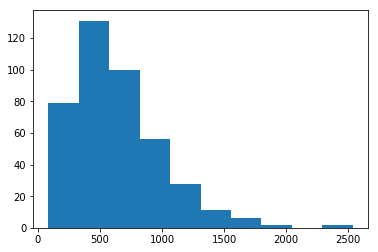

In [72]:
plt.hist(par_lengths)

In [78]:
np.std(par_lengths)

366.2057912888913

In [92]:
int(np.std(par_lengths))

366

In [88]:
tok_hits1[0]

[158230, 158240]

In [93]:
# defin paragraph with added margin
par1 = string_filing[tok_hits1[0][0] - int(np.std(par_lengths)) : tok_hits1[0][1] + int(np.std(par_lengths))]
par1

'pensation plans\n\nthe information included under item 12 of part iii of this report, "security ownership of\ncertain beneficial owners and management and related stockholder matters," is hereby incorporated by reference\ninto this item 5 of part ii of this report.\n\npurchases of equity securities\n\non february 21, 2014, our board of directors approved or current share repurchase program,\nauthorizing us to acquire up to an aggregate of 20 million shares of our common stock. the program allows us to\nrepurchase shares of our common stock from time to time for cash in the open market, or in negotiated or block\ntransactions, as market and business conditions warrant and subject to applicable legal requirements. there is\nno expiration date for'

In [94]:
print(par1)

pensation plans

the information included under item 12 of part iii of this report, "security ownership of
certain beneficial owners and management and related stockholder matters," is hereby incorporated by reference
into this item 5 of part ii of this report.

purchases of equity securities

on february 21, 2014, our board of directors approved or current share repurchase program,
authorizing us to acquire up to an aggregate of 20 million shares of our common stock. the program allows us to
repurchase shares of our common stock from time to time for cash in the open market, or in negotiated or block
transactions, as market and business conditions warrant and subject to applicable legal requirements. there is
no expiration date for


## Merge overlapping Paragraphs